In [2]:
import shapefile
from pyproj import Proj, transform
from mpl_toolkits.basemap import Basemap
import matplotlib.pyplot as plt
import pandas as pd
from shapely.geometry import Point, Polygon
import sys
sys.path.append('../parsing')
import accessDB as db
%matplotlib inline

# data from https://city.milwaukee.gov/DownloadMapData3497.htm
# it is encoded in NAD27 in zone 4803 (Wisconsin South)

In [3]:
# open a single file
#f = open('ald2012.shp', 'rb')
#sf = shapefile.Reader(shp=f)

# load in maps
ald = shapefile.Reader('ald2016/alderman')
nbh = shapefile.Reader('hoods/neighborhood')
pol = shapefile.Reader('poldist/poldist')
ward = shapefile.Reader('wards/ward')
city = shapefile.Reader('corp/citylimit')

In [4]:
# converter for coordinates
inProj = Proj(init='EPSG:32054', preserve_units=True) # NAD27 Wisconsin South
outProj = Proj(proj='latlong', datum='WGS84', ellps='WGS84') # Latitude and Longitude

In [5]:
# read in a geolocated dataset
df = db.filter(nature='THEFT', doGeoLoc=True)
df.head()

/usr/local/lib/python2.7/dist-packages/pandas/core/frame.py:3140: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  self[k1] = value[k2]


,Call Number,Date/Time,Location,Police District,Nature of Call,Status,Latitude,Longitude
ID,,,,,,,,
182550941-Service in Progress,182550941,2018-09-12 12:27:05,"1320 W BURNHAM ST,MKE",2,THEFT,Service in Progress,43.0108,-87.9288
182550941-Assignment Completed,182550941,2018-09-12 12:27:05,"1320 W BURNHAM ST,MKE",2,THEFT,Assignment Completed,43.0108,-87.9288
182551062-Service in Progress,182551062,2018-09-12 12:33:42,"345 W ST PAUL AV,MKE",1,THEFT,Service in Progress,43.0346,-87.922
182551227-Advised,182551227,2018-09-12 12:42:46,"230 S 76TH ST,MKE",3,THEFT,Advised,NaN,NaN
182551188-To be Filed,182551188,2018-09-12 13:25:40,"2642 S 29TH ST,MKE",2,THEFT,To be Filed,NaN,NaN


In [6]:
# parse the latitude and longitude of the coordinates column
#split = df['Coordinates'].str.split(',', 1, expand=True)
#df['lat'] = split[0].str.replace('{\'lat\': ', '').astype(float)
#df['long'] = split[1].str.replace('\'lng\': ', '')
#df['long'] = df['long'].str.replace('}', '').astype(float)

In [7]:
# create a new dataframe with just the coordinates
coords = df[['Latitude', 'Longitude']]
coords = coords.dropna()
# some empty are missed I guess
coords = coords[coords['Latitude'] != '']
coords = coords[coords['Longitude'] != '']
coords.head()

,Latitude,Longitude
ID,,
182550941-Service in Progress,43.0108,-87.9288
182550941-Assignment Completed,43.0108,-87.9288
182551062-Service in Progress,43.0346,-87.922
182552258-Unable to Locate Complainant,43.0599,-87.8901
182552258-Open Investigation,43.0599,-87.8901


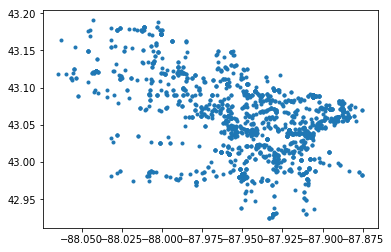

In [8]:
# just plot the points to confirms they're there
plt.plot(coords['Longitude'], coords['Latitude'], '.')

In [9]:
def plotOn(sf, coords, sfName, drawMap=False):
    # initialize plot size
    plt.figure(figsize=(10,18)) # approx dimensions of MKE is 5:9
    if not drawMap:
        # limit bounds of the plot
        plt.xlim(-88.1,-87.85)
        plt.ylim(42.9,43.2)
        m = plt
    else:
        # attempt to draw a map, it's not working
        m = Basemap(llcrnrlon=-88.1, llcrnrlat=42.9, urcrnrlon=-87.85, urcrnrlat=43.2, 
                    lon_0=(-88.1 + -87.85)/2, lat_0=(42.9 + 43.2)/2, 
                    resolution='i', projection='tmerc')
        m.drawcoastlines()
        m.drawrivers()
        m.drawmapboundary()
        m.fillcontinents(color='#ddaa66',lake_color='aqua')

    # loop through shapes
    polys = []
    for i,shape in enumerate(sf.shapes()):
        xs = []
        ys = []
        points = []

        # loop through points
        for point in shape.points:
            # parse points
            coord = [float('%.3f' % coord) for coord in point]
            # convert points
            x, y = transform(inProj, outProj, coord[0], coord[1])
            # add to list
            xs.append(x)
            ys.append(y)
            points.append((x, y))
            
        # make a polygon out of the points
        poly = Polygon(points)
        polys.append(poly)
        
        # find the district, ward, etc that a point is in
        for index, row in coords.iterrows():
            point = Point(row['Longitude'], row['Latitude'])
            if poly.contains(point):
                coords.loc[index, sfName] = i

        # plot shape
        m.plot(xs, ys, '-')

    #for index, row in coords.iterrows():
    m.plot(coords['Longitude'], coords['Latitude'], '.')

    plt.show()
    return polys

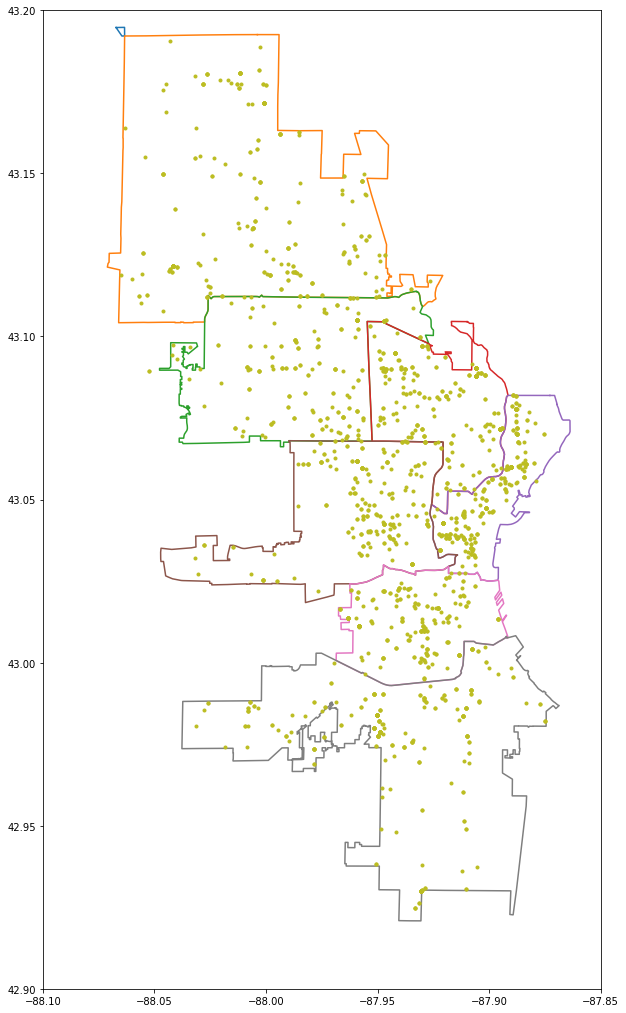

In [10]:
polys = plotOn(pol, coords, 'Police District')

In [11]:
coords.head()

,Latitude,Longitude,Police District
ID,,,
182550941-Service in Progress,43.0108,-87.9288,6.0
182550941-Assignment Completed,43.0108,-87.9288,6.0
182551062-Service in Progress,43.0346,-87.922,4.0
182552258-Unable to Locate Complainant,43.0599,-87.8901,4.0
182552258-Open Investigation,43.0599,-87.8901,4.0
